## CREATE SPARK SESSION 

In [1]:
##link_dataset: https://www.kaggle.com/datasets/rushikeshdane20/nashik-apartment-price-prediction

from pyspark.sql import SparkSession
from pyspark.sql import functions
spark = SparkSession.builder.appName('pyspark - example join').getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=PySparkShell>

## Import dataset

In [2]:
dname = "project_biglab.csv"
datapath = os.path.join("/Users/matteofercia/Desktop/datascience/lab_bigdata/project")

In [3]:
#to read directly a csv file with spark without have to pass from pandas
df = spark.read.csv(os.path.join(datapath,dname), header=True, inferSchema=True)

In [4]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- owners: string (nullable = true)
 |-- housetype: string (nullable = true)
 |-- house_condition: string (nullable = true)
 |-- BHK: double (nullable = true)
 |-- price: double (nullable = true)
 |-- per_month_emi: double (nullable = true)
 |-- total_sqft: double (nullable = true)
 |-- cordinates: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [5]:
df.show(2)

+---+--------------------+---------------+---------+---------------+---+-----+-------------+----------+------------------+------------------+-----------------+
|_c0|             address|         owners|housetype|house_condition|BHK|price|per_month_emi|total_sqft|        cordinates|          latitude|        longitude|
+---+--------------------+---------------+---------+---------------+---+-----+-------------+----------+------------------+------------------+-----------------+
|  0|Sheetal Vihar, Bh...|Mahendra Kotwal|Apartment|            old|3.0| 75.0|        39.72|    1550.0|     Sheetal Vihar|19.987960000000047|73.78739000000007|
|  1|Samraat Dream Cit...| Jiten Dadarkar|Apartment|            old|2.0| 41.0|        21.71|    1000.0|Samraat Dream Citi| 19.98246000000006|73.81184000000006|
+---+--------------------+---------------+---------+---------------+---+-----+-------------+----------+------------------+------------------+-----------------+
only showing top 2 rows



22/04/26 15:28:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , address, owners, housetype, house_condition, BHK, price, per_month_emi, total_sqft, cordinates, latitude, longitude
 Schema: _c0, address, owners, housetype, house_condition, BHK, price, per_month_emi, total_sqft, cordinates, latitude, longitude
Expected: _c0 but found: 
CSV file: file:///Users/matteofercia/Desktop/datascience/lab_bigdata/project/project_biglab.csv


In [6]:
df.count()  #n rows in the df

5496

In [7]:
df.columns

['_c0',
 'address',
 'owners',
 'housetype',
 'house_condition',
 'BHK',
 'price',
 'per_month_emi',
 'total_sqft',
 'cordinates',
 'latitude',
 'longitude']

In [8]:
#Dupplicate the df to drop some columns we are not interested in 
df2 = df.alias('df2')

In [9]:
#df2.show(2)
df2.columns

['_c0',
 'address',
 'owners',
 'housetype',
 'house_condition',
 'BHK',
 'price',
 'per_month_emi',
 'total_sqft',
 'cordinates',
 'latitude',
 'longitude']

In [10]:
df2 = df2.drop('_c0','address','latitude','longitude','owners')

# Drop na and cleaning

In [11]:
df2 = df2.where("total_sqft<25000") #cutting outlier in total_sqft

In [12]:
df2 = df2.where("per_month_emi<300") #cutting oper month emi over 300

In [13]:
df2 = df2.na.drop()

In [14]:
df2.printSchema()

root
 |-- housetype: string (nullable = true)
 |-- house_condition: string (nullable = true)
 |-- BHK: double (nullable = true)
 |-- price: double (nullable = true)
 |-- per_month_emi: double (nullable = true)
 |-- total_sqft: double (nullable = true)
 |-- cordinates: string (nullable = true)



In [15]:
df2.show(2)

+---------+---------------+---+-----+-------------+----------+------------------+
|housetype|house_condition|BHK|price|per_month_emi|total_sqft|        cordinates|
+---------+---------------+---+-----+-------------+----------+------------------+
|Apartment|            old|3.0| 75.0|        39.72|    1550.0|     Sheetal Vihar|
|Apartment|            old|2.0| 41.0|        21.71|    1000.0|Samraat Dream Citi|
+---------+---------------+---+-----+-------------+----------+------------------+
only showing top 2 rows



In [16]:
#transform some column type from string to numbers and boolean
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.types import DoubleType
from pyspark.sql.types import BooleanType
from pyspark.sql.types import StringType

In [17]:
from pyspark.ml.feature import StringIndexer

In [19]:
indexed = StringIndexer(inputCol="house_condition", outputCol="house_condition_x").fit(df2).transform(df2)
indexed = StringIndexer(inputCol="housetype", outputCol="housetype_x").fit(indexed).transform(indexed)

In [20]:
indexed.printSchema()

root
 |-- housetype: string (nullable = true)
 |-- house_condition: string (nullable = true)
 |-- BHK: double (nullable = true)
 |-- price: double (nullable = true)
 |-- per_month_emi: double (nullable = true)
 |-- total_sqft: double (nullable = true)
 |-- cordinates: string (nullable = true)
 |-- house_condition_x: double (nullable = false)
 |-- housetype_x: double (nullable = false)



In [21]:
indexed = indexed.drop("owners","housetype","house_condition","cordinates")

In [22]:
indexed.show(3)

+---+-----+-------------+----------+-----------------+-----------+
|BHK|price|per_month_emi|total_sqft|house_condition_x|housetype_x|
+---+-----+-------------+----------+-----------------+-----------+
|3.0| 75.0|        39.72|    1550.0|              0.0|        0.0|
|2.0| 41.0|        21.71|    1000.0|              0.0|        0.0|
|2.0|53.35|        28.25|     970.0|              0.0|        0.0|
+---+-----+-------------+----------+-----------------+-----------+
only showing top 3 rows



In [23]:
features = [ x for x in indexed.columns ]
features

['BHK',
 'price',
 'per_month_emi',
 'total_sqft',
 'house_condition_x',
 'housetype_x']

In [24]:
features.remove('price')

In [25]:
features

['BHK', 'per_month_emi', 'total_sqft', 'house_condition_x', 'housetype_x']

## Assembling

In [26]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [27]:
assembler= VectorAssembler(inputCols=features, outputCol="features")

In [28]:
assembler

VectorAssembler_45dc04ce9e45

In [29]:
assembled = assembler.transform(indexed)

In [30]:
assembled

DataFrame[BHK: double, price: double, per_month_emi: double, total_sqft: double, house_condition_x: double, housetype_x: double, features: vector]

In [31]:
assembled.select("features","price").show(5, truncate=False)

+--------------------------+-----+
|features                  |price|
+--------------------------+-----+
|[3.0,39.72,1550.0,0.0,0.0]|75.0 |
|[2.0,21.71,1000.0,0.0,0.0]|41.0 |
|[2.0,28.25,970.0,0.0,0.0] |53.35|
|[2.0,29.13,1000.0,0.0,0.0]|55.0 |
|[2.0,14.3,853.0,0.0,0.0]  |27.0 |
+--------------------------+-----+
only showing top 5 rows



In [32]:
assembled

DataFrame[BHK: double, price: double, per_month_emi: double, total_sqft: double, house_condition_x: double, housetype_x: double, features: vector]

In [33]:
data = assembled.select("features","price")
data.show(5, truncate=False)

+--------------------------+-----+
|features                  |price|
+--------------------------+-----+
|[3.0,39.72,1550.0,0.0,0.0]|75.0 |
|[2.0,21.71,1000.0,0.0,0.0]|41.0 |
|[2.0,28.25,970.0,0.0,0.0] |53.35|
|[2.0,29.13,1000.0,0.0,0.0]|55.0 |
|[2.0,14.3,853.0,0.0,0.0]  |27.0 |
+--------------------------+-----+
only showing top 5 rows



## Scaling data 

In [34]:
from pyspark.ml.feature import MinMaxScaler

In [35]:
scaler = MinMaxScaler(inputCol='features', outputCol="scaled_features")

In [36]:
features

['BHK', 'per_month_emi', 'total_sqft', 'house_condition_x', 'housetype_x']

In [37]:
scaler

MinMaxScaler_e89cafd688fb

In [38]:
scaled = scaler.fit(data).transform(data)

In [39]:
scaled

DataFrame[features: vector, price: double, scaled_features: vector]

In [40]:
scaled.show(5)

+--------------------+-----+--------------------+
|            features|price|     scaled_features|
+--------------------+-----+--------------------+
|[3.0,39.72,1550.0...| 75.0|[0.22222222222222...|
|[2.0,21.71,1000.0...| 41.0|[0.11111111111111...|
|[2.0,28.25,970.0,...|53.35|[0.11111111111111...|
|[2.0,29.13,1000.0...| 55.0|[0.11111111111111...|
|[2.0,14.3,853.0,0...| 27.0|[0.11111111111111...|
+--------------------+-----+--------------------+
only showing top 5 rows



# Plotting

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
pandas_df2 = df2.toPandas() #moving the df on pandas to use matplotlib

<AxesSubplot:xlabel='price', ylabel='BHK'>

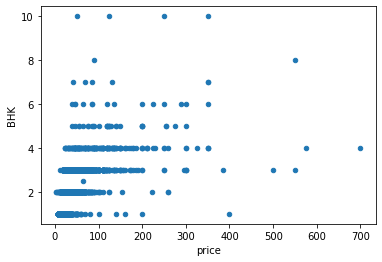

In [43]:
pandas_df2.plot.scatter(x='price', y='BHK')  

<AxesSubplot:xlabel='price', ylabel='housetype'>

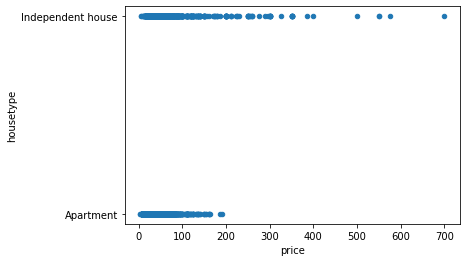

In [44]:
pandas_df2.plot.scatter(x='price', y='housetype')  

<AxesSubplot:xlabel='price', ylabel='total_sqft'>

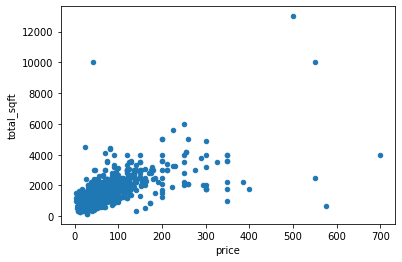

In [45]:
pandas_df2.plot.scatter(x='price', y='total_sqft')

<AxesSubplot:xlabel='price', ylabel='house_condition'>

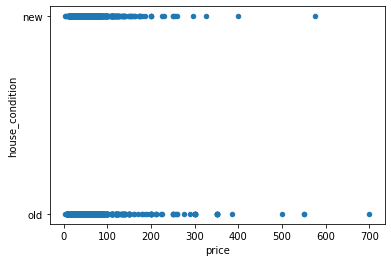

In [46]:
pandas_df2.plot.scatter(x='price', y='house_condition')

<AxesSubplot:xlabel='price', ylabel='per_month_emi'>

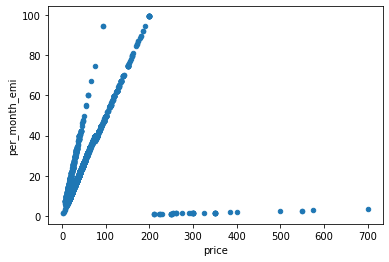

In [47]:
pandas_df2.plot.scatter(x='price', y='per_month_emi')

# Dividing Training and Test

### To perform our ML analysis we devide the main df into train and test set

In [48]:
selected = assembled.select('features','price')

In [49]:
selected

DataFrame[features: vector, price: double]

In [50]:
training_set, test_set = data.randomSplit([0.8,0.2], seed=0)
training_set.tail(2)

[Row(features=DenseVector([10.0, 26.48, 1520.0, 0.0, 1.0]), price=50.0),
 Row(features=DenseVector([10.0, 62.06, 2500.0, 1.0, 1.0]), price=125.0)]

In [51]:
training_set.show(3)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[1.0,1.99,1800.0,...|400.0|
|[1.0,3.71,360.0,0...|  7.0|
|[1.0,4.24,350.0,0...|  8.0|
+--------------------+-----+
only showing top 3 rows



In [52]:
test_set.printSchema()

root
 |-- features: vector (nullable = true)
 |-- price: double (nullable = true)



In [53]:
test_set.show(2)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[1.0,6.09,270.0,0...| 11.5|
|[1.0,6.35,250.0,1...| 12.0|
+--------------------+-----+
only showing top 2 rows



# Linear regression 1 and 2

In [54]:
from pyspark.ml.regression import LinearRegression as LinearRegressor

In [55]:
regressor = LinearRegressor(featuresCol='features', labelCol='price',predictionCol='prediction')

In [155]:
model = regressor.fit(training_set)

In [57]:
test_data = test_set.select('features')

In [58]:
training_data = training_set.select('features')

In [59]:
predictions_training = model.transform(training_data)

In [60]:
predictions_training.show(5)

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[1.0,1.99,1800.0,...| 69.49322356076289|
|[1.0,3.71,360.0,0...|0.5287385068777049|
|[1.0,4.24,350.0,0...|0.2832368996486032|
|[1.0,4.77,600.0,0...|17.812485324393457|
|[1.0,4.77,1000.0,...| 33.92971377545115|
+--------------------+------------------+
only showing top 5 rows



In [61]:
predictions_test = model.transform(test_data)

In [62]:
predictions_test.show(5)


+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[1.0,6.09,270.0,0...|-2.390692106624103|
|[1.0,6.35,250.0,1...| 8.334040470737726|
|[1.0,6.35,650.0,1...|17.152717383008977|
|[1.0,6.35,1100.0,...| 35.28459939044888|
|[1.0,6.62,525.0,0...|15.340021673758969|
+--------------------+------------------+
only showing top 5 rows



In [63]:
training_set.show(10)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[1.0,1.99,1800.0,...|400.0|
|[1.0,3.71,360.0,0...|  7.0|
|[1.0,4.24,350.0,0...|  8.0|
|[1.0,4.77,600.0,0...|  9.0|
|[1.0,4.77,1000.0,...|  9.0|
|[1.0,5.03,350.0,0...|  9.5|
|[1.0,5.03,400.0,0...|  9.5|
|[1.0,5.3,370.0,1....| 10.0|
|[1.0,5.3,400.0,0....| 10.0|
|[1.0,5.3,430.0,1....| 10.0|
+--------------------+-----+
only showing top 10 rows



In [64]:
training_result = model.evaluate(training_set)

In [65]:
print('RMSE:{}'.format(training_result.rootMeanSquaredError))
print('MSE:{}'.format(training_result.meanSquaredError))
print('R2:{}'.format(model.summary.r2))

RMSE:28.025518616786623
MSE:785.4296937398535
R2:0.5533982270280893


In [66]:
test_set.show(3)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[1.0,6.09,270.0,0...| 11.5|
|[1.0,6.35,250.0,1...| 12.0|
|[1.0,6.35,650.0,1...| 12.0|
+--------------------+-----+
only showing top 3 rows



In [67]:
test_result = model.evaluate(test_set)

In [68]:
print('RMSE:{}'.format(test_result.rootMeanSquaredError))
print('MSE:{}'.format(test_result.meanSquaredError))
print('R2:{}'.format(test_result.r2))

RMSE:28.91383637946014
MSE:836.0099341781927
R2:0.4469033588333813


In [69]:
price_target = test_set.select('price')

In [70]:
price_target.show(5)

+-----+
|price|
+-----+
| 11.5|
| 12.0|
| 12.0|
| 12.0|
| 12.5|
+-----+
only showing top 5 rows



In [71]:
performance = model.evaluate(test_set)

In [72]:
performance.meanSquaredError

836.0099341781927

In [73]:
prediction = performance.predictions.select('prediction')

/usr/local/Cellar/apache-spark/3.2.1/libexec/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [74]:
prediction.show(5)

+------------------+
|        prediction|
+------------------+
|-2.390692106624103|
| 8.334040470737726|
|17.152717383008977|
| 35.28459939044888|
|15.340021673758969|
+------------------+
only showing top 5 rows



In [75]:
import matplotlib.pyplot as plt
price_points = [ item.price for item in price_target.collect()]

In [76]:
price_points[:10]

[11.5, 12.0, 12.0, 12.0, 12.5, 6.8, 12.91, 13.0, 13.0, 13.5]

In [77]:
pred_points = [ item.prediction for item in prediction.collect() ]

In [78]:
pred_points[:10]

[-2.390692106624103,
 8.334040470737726,
 17.152717383008977,
 35.28459939044888,
 15.340021673758969,
 7.893471267501322,
 14.67921542194454,
 11.185599675654387,
 17.184640510489288,
 19.65226386713777]

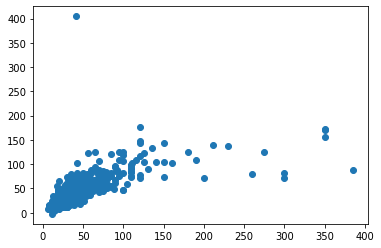

In [79]:
plt.scatter(price_points, pred_points)

### We can observe in this graph our model performs very well for prices from 0 to 150 and quite bad from 151 to upper values, we are going to reduce our dataset to focus on the relation 0-150

## Linear regression 1 with price from 0 to 150

In [80]:
data.show(5, truncate=False)

+--------------------------+-----+
|features                  |price|
+--------------------------+-----+
|[3.0,39.72,1550.0,0.0,0.0]|75.0 |
|[2.0,21.71,1000.0,0.0,0.0]|41.0 |
|[2.0,28.25,970.0,0.0,0.0] |53.35|
|[2.0,29.13,1000.0,0.0,0.0]|55.0 |
|[2.0,14.3,853.0,0.0,0.0]  |27.0 |
+--------------------------+-----+
only showing top 5 rows



In [81]:
data_2 = data.where("price<150") 

In [82]:
data_2.count()

3784

In [83]:
data_2.show(5)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|[3.0,39.72,1550.0...| 75.0|
|[2.0,21.71,1000.0...| 41.0|
|[2.0,28.25,970.0,...|53.35|
|[2.0,29.13,1000.0...| 55.0|
|[2.0,14.3,853.0,0...| 27.0|
+--------------------+-----+
only showing top 5 rows



In [84]:
training_set_2, test_set_2 = data_2.randomSplit([0.8,0.2], seed=0)
training_set_2.tail(2)

[Row(features=DenseVector([10.0, 26.48, 1520.0, 0.0, 1.0]), price=50.0),
 Row(features=DenseVector([10.0, 62.06, 2500.0, 1.0, 1.0]), price=125.0)]

In [85]:
regressor = LinearRegressor(featuresCol='features', labelCol='price',predictionCol='prediction')

In [86]:
model_2 = regressor.fit(training_set_2)

22/04/26 15:29:48 WARN Instrumentation: [26a8c028] regParam is zero, which might cause numerical instability and overfitting.


In [87]:
test_data_2 = test_set_2.select('features')

In [88]:
training_data_2 = training_set_2.select('features')

In [89]:
predictions_training_2 = model.transform(training_data_2)

In [90]:
predictions_test_2 = model_2.transform(test_data_2)

In [91]:
training_result_2 = model_2.evaluate(training_set_2)

In [92]:
print('RMSE:{}'.format(training_result_2.rootMeanSquaredError))
print('MSE:{}'.format(training_result_2.meanSquaredError))
print('R2:{}'.format(model_2.summary.r2))

RMSE:6.937765963946868
MSE:48.132596570499615
R2:0.9107088603043545


In [93]:
test_result_2 = model_2.evaluate(test_set_2)

In [94]:
print('RMSE:{}'.format(test_result_2.rootMeanSquaredError))
print('MSE:{}'.format(test_result_2.meanSquaredError))
print('R2:{}'.format(test_result_2.r2))

RMSE:7.044651043806006
MSE:49.627108328997046
R2:0.9132138990781951


In [95]:
price_target_2 = test_set_2.select('price')

In [96]:
price_points_2 = [ item.price for item in price_target_2.collect()]

In [97]:
performance_2 = model_2.evaluate(test_set_2)

In [98]:
prediction_2 = performance_2.predictions.select('prediction')

In [99]:
pred_points_2 = [ item.prediction for item in prediction_2.collect() ]

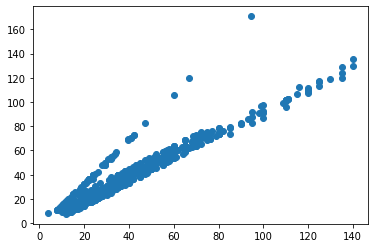

In [100]:
plt.scatter(price_points_2, pred_points_2)

# Linear regression 3 only with double features

In [101]:
df3 = df.alias('df3')

In [102]:
df3 = df3.where("total_sqft<25000") #cutting outlier in total_sqft

In [103]:
df3 = df3.where("per_month_emi<300") #cutting per month emi over 300

In [104]:
df3 = df3.drop('_c0','address','latitude','longitude','owners','housetype','house_condition','cordinates')

In [105]:
df3 = df3.na.drop()

In [106]:
df3.printSchema()

root
 |-- BHK: double (nullable = true)
 |-- price: double (nullable = true)
 |-- per_month_emi: double (nullable = true)
 |-- total_sqft: double (nullable = true)



In [107]:
df3.show(3)

+---+-----+-------------+----------+
|BHK|price|per_month_emi|total_sqft|
+---+-----+-------------+----------+
|3.0| 75.0|        39.72|    1550.0|
|2.0| 41.0|        21.71|    1000.0|
|2.0|53.35|        28.25|     970.0|
+---+-----+-------------+----------+
only showing top 3 rows



In [108]:
features_3 = [ x for x in df3.columns ]
features_3

['BHK', 'price', 'per_month_emi', 'total_sqft']

In [109]:
features_3.remove('price')

In [110]:
assembler_3= VectorAssembler(inputCols=features_3, outputCol="features_3")

In [111]:
assembler_3

VectorAssembler_ecd16acb56b4

In [112]:
assembled_3 = assembler_3.transform(df3)

In [113]:
assembled_3

DataFrame[BHK: double, price: double, per_month_emi: double, total_sqft: double, features_3: vector]

In [114]:
assembled_3.select("features_3","price").show(5, truncate=False)

+------------------+-----+
|features_3        |price|
+------------------+-----+
|[3.0,39.72,1550.0]|75.0 |
|[2.0,21.71,1000.0]|41.0 |
|[2.0,28.25,970.0] |53.35|
|[2.0,29.13,1000.0]|55.0 |
|[2.0,14.3,853.0]  |27.0 |
+------------------+-----+
only showing top 5 rows



In [115]:
data_3 = assembled_3.select("features_3","price")
data_3.show(5, truncate=False)

+------------------+-----+
|features_3        |price|
+------------------+-----+
|[3.0,39.72,1550.0]|75.0 |
|[2.0,21.71,1000.0]|41.0 |
|[2.0,28.25,970.0] |53.35|
|[2.0,29.13,1000.0]|55.0 |
|[2.0,14.3,853.0]  |27.0 |
+------------------+-----+
only showing top 5 rows



In [116]:
training_set, test_set = data_3.randomSplit([0.8,0.2], seed=0)
training_set.tail(2)

[Row(features_3=DenseVector([10.0, 26.48, 1520.0]), price=50.0),
 Row(features_3=DenseVector([10.0, 62.06, 2500.0]), price=125.0)]

In [117]:
regressor = LinearRegressor(featuresCol='features_3', labelCol='price',predictionCol='prediction')

In [118]:
model = regressor.fit(training_set)

22/04/26 15:30:02 WARN Instrumentation: [54a8f8fd] regParam is zero, which might cause numerical instability and overfitting.


In [119]:
test_data = test_set.select('features_3')

In [120]:
training_data = training_set.select('features_3')

In [121]:
predictions_training = model.transform(training_data)

In [122]:
predictions_training.show(5)

+-----------------+------------------+
|       features_3|        prediction|
+-----------------+------------------+
|[1.0,1.99,1800.0]| 62.10357002430814|
| [1.0,3.71,360.0]| 2.816943907572167|
| [1.0,4.24,350.0]|2.5633099517215214|
| [1.0,4.77,600.0]|13.108968185991262|
|[1.0,4.77,1000.0]| 29.72326386309955|
+-----------------+------------------+
only showing top 5 rows



In [123]:
predictions_test = model.transform(test_data)

In [124]:
predictions_test.show(5)

+-----------------+-------------------+
|       features_3|         prediction|
+-----------------+-------------------+
| [1.0,6.09,270.0]|-0.1950428502236008|
| [1.0,6.35,250.0]|-0.9464216088336652|
| [1.0,6.35,650.0]| 15.667874068274624|
|[1.0,6.35,1100.0]|  34.35895670502144|
| [1.0,6.62,525.0]| 10.558294080009993|
+-----------------+-------------------+
only showing top 5 rows



In [125]:
training_result = model.evaluate(training_set)

In [126]:
print('RMSE:{}'.format(training_result.rootMeanSquaredError))
print('MSE:{}'.format(training_result.meanSquaredError))
print('R2:{}'.format(model.summary.r2))

RMSE:28.23249179598749
MSE:797.0735930105009
R2:0.5467774574652765


In [127]:
test_result = model.evaluate(test_set)

In [128]:
print('RMSE:{}'.format(test_result.rootMeanSquaredError))
print('MSE:{}'.format(test_result.meanSquaredError))
print('R2:{}'.format(test_result.r2))

RMSE:29.11187551757263
MSE:847.5012961506449
R2:0.43930052705147604


# Clustering

In [129]:
df3 = df3.where("total_sqft<6000")

In [130]:
df3.show(3)

+---+-----+-------------+----------+
|BHK|price|per_month_emi|total_sqft|
+---+-----+-------------+----------+
|3.0| 75.0|        39.72|    1550.0|
|2.0| 41.0|        21.71|    1000.0|
|2.0|53.35|        28.25|     970.0|
+---+-----+-------------+----------+
only showing top 3 rows



In [131]:
assembler = VectorAssembler(inputCols=['BHK','price','per_month_emi','total_sqft'], outputCol='features')

In [132]:
output = assembler.transform(df3)

In [133]:
output.printSchema()

root
 |-- BHK: double (nullable = true)
 |-- price: double (nullable = true)
 |-- per_month_emi: double (nullable = true)
 |-- total_sqft: double (nullable = true)
 |-- features: vector (nullable = true)



In [134]:
output.show(3)

+---+-----+-------------+----------+--------------------+
|BHK|price|per_month_emi|total_sqft|            features|
+---+-----+-------------+----------+--------------------+
|3.0| 75.0|        39.72|    1550.0|[3.0,75.0,39.72,1...|
|2.0| 41.0|        21.71|    1000.0|[2.0,41.0,21.71,1...|
|2.0|53.35|        28.25|     970.0|[2.0,53.35,28.25,...|
+---+-----+-------------+----------+--------------------+
only showing top 3 rows



## Scaling

In [135]:
from pyspark.ml.feature import StandardScaler

In [136]:
scaler = StandardScaler(inputCol='features',outputCol='scaled', withStd=True,withMean=False)

In [137]:
model = scaler.fit(output)

In [138]:
output = model.transform(output)

In [139]:
output.show(10)

+---+-----+-------------+----------+--------------------+--------------------+
|BHK|price|per_month_emi|total_sqft|            features|              scaled|
+---+-----+-------------+----------+--------------------+--------------------+
|3.0| 75.0|        39.72|    1550.0|[3.0,75.0,39.72,1...|[3.27833242443844...|
|2.0| 41.0|        21.71|    1000.0|[2.0,41.0,21.71,1...|[2.18555494962562...|
|2.0|53.35|        28.25|     970.0|[2.0,53.35,28.25,...|[2.18555494962562...|
|2.0| 55.0|        29.13|    1000.0|[2.0,55.0,29.13,1...|[2.18555494962562...|
|2.0| 27.0|         14.3|     853.0|[2.0,27.0,14.3,85...|[2.18555494962562...|
|2.0| 42.0|        22.24|    1050.0|[2.0,42.0,22.24,1...|[2.18555494962562...|
|2.0| 35.5|         18.8|    1035.0|[2.0,35.5,18.8,10...|[2.18555494962562...|
|3.0| 48.0|        25.42|    1375.0|[3.0,48.0,25.42,1...|[3.27833242443844...|
|2.0| 32.0|        16.95|     850.0|[2.0,32.0,16.95,8...|[2.18555494962562...|
|2.0| 32.0|        16.95|    1020.0|[2.0,32.0,16.95,

In [140]:
output.select('scaled').show(10, False)

+-----------------------------------------------------------------------------+
|scaled                                                                       |
+-----------------------------------------------------------------------------+
|[3.2783324244384406,1.8884038895832995,2.924065209751943,2.8630451536125103] |
|[2.1855549496256272,1.0323274596388705,1.5982239603150727,1.8471259055564582]|
|[2.1855549496256272,1.3432846334569204,2.0796788060295164,1.7917121283897643]|
|[2.1855549496256272,1.384829519027753,2.144461721049197,1.8471259055564582]  |
|[2.1855549496256272,0.6798254002499878,1.0527223690698084,1.5755983974396588]|
|[2.1855549496256272,1.0575061781666477,1.6372409432246529,1.9394822008342811]|
|[2.1855549496256272,0.8938445077360951,1.3839986390568109,1.9117753122509342]|
|[3.2783324244384406,1.2085784893333118,1.8713428406821349,2.53979812014013]  |
|[2.1855549496256272,0.8057189928888745,1.2478072836177099,1.5700570197229895]|
|[2.1855549496256272,0.8057189928888745,

## Performing K-means clustering with 3 cluster

In [141]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [142]:
kmeans = KMeans(featuresCol='scaled', k=3)

In [143]:
model = kmeans.fit(output)

In [144]:
predictions_3 = model.transform(output)

In [145]:
predictions_3.show(10)

+---+-----+-------------+----------+--------------------+--------------------+----------+
|BHK|price|per_month_emi|total_sqft|            features|              scaled|prediction|
+---+-----+-------------+----------+--------------------+--------------------+----------+
|3.0| 75.0|        39.72|    1550.0|[3.0,75.0,39.72,1...|[3.27833242443844...|         1|
|2.0| 41.0|        21.71|    1000.0|[2.0,41.0,21.71,1...|[2.18555494962562...|         0|
|2.0|53.35|        28.25|     970.0|[2.0,53.35,28.25,...|[2.18555494962562...|         0|
|2.0| 55.0|        29.13|    1000.0|[2.0,55.0,29.13,1...|[2.18555494962562...|         0|
|2.0| 27.0|         14.3|     853.0|[2.0,27.0,14.3,85...|[2.18555494962562...|         0|
|2.0| 42.0|        22.24|    1050.0|[2.0,42.0,22.24,1...|[2.18555494962562...|         0|
|2.0| 35.5|         18.8|    1035.0|[2.0,35.5,18.8,10...|[2.18555494962562...|         0|
|3.0| 48.0|        25.42|    1375.0|[3.0,48.0,25.42,1...|[3.27833242443844...|         1|
|2.0| 32.0

In [146]:
tester = ClusteringEvaluator()

In [147]:
silhouette = tester.evaluate(predictions_3)

In [148]:
print(silhouette)

0.6252080690780363


In [149]:
centers = model.clusterCenters()

In [150]:
print('*** Cluster centers ***')
for center in centers: print(center)

*** Cluster centers ***
[1.87355567 0.73861699 1.21658287 1.61093177]
[3.42627933 1.81358618 2.86436784 3.07381612]
[4.61698483 7.8179921  0.11353574 5.48079199]


In [151]:
summary = [ silhouette ] # store the silhouette with n=3

for n in range(4,10):
    kmeans = KMeans(featuresCol='scaled', k=n)
    model = kmeans.fit(output)
    predictions = model.transform(output)
    silhouette = tester.evaluate(predictions)
    summary += [ silhouette ]
    print(f"Num of clusters: {n} -- Silhouette with euclidean distance: {silhouette}")

Num of clusters: 4 -- Silhouette with euclidean distance: 0.5991722847638973
Num of clusters: 5 -- Silhouette with euclidean distance: 0.36200952170911493
Num of clusters: 6 -- Silhouette with euclidean distance: 0.41320249981892915
Num of clusters: 7 -- Silhouette with euclidean distance: 0.35445302388614497
Num of clusters: 8 -- Silhouette with euclidean distance: 0.2377083367943641
Num of clusters: 9 -- Silhouette with euclidean distance: 0.1747746845153798


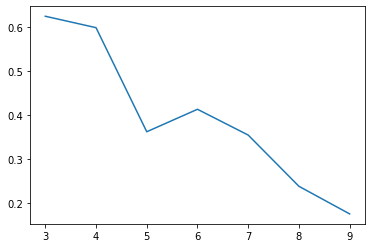

In [152]:
plt.plot(range(3,9+1),summary)

In [153]:
pd_predictions = predictions_3.toPandas()
pd_predictions.head()

,BHK,price,per_month_emi,total_sqft,features,scaled,prediction
0,3.0,75.00,39.72,1550.0,"[3.0, 75.0, 39.72, 1550.0]","[3.2783324244384406, 1.8884038895832995, 2.924...",1
1,2.0,41.00,21.71,1000.0,"[2.0, 41.0, 21.71, 1000.0]","[2.1855549496256272, 1.0323274596388705, 1.598...",0
2,2.0,53.35,28.25,970.0,"[2.0, 53.35, 28.25, 970.0]","[2.1855549496256272, 1.3432846334569204, 2.079...",0
3,2.0,55.00,29.13,1000.0,"[2.0, 55.0, 29.13, 1000.0]","[2.1855549496256272, 1.384829519027753, 2.1444...",0
4,2.0,27.00,14.30,853.0,"[2.0, 27.0, 14.3, 853.0]","[2.1855549496256272, 0.6798254002499878, 1.052...",0


/var/folders/v3/1bsc9h616vj6zjgdf5wv5v3m0000gn/T/ipykernel_4534/1454013525.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure(figsize=(12,10)).gca(projection='3d')


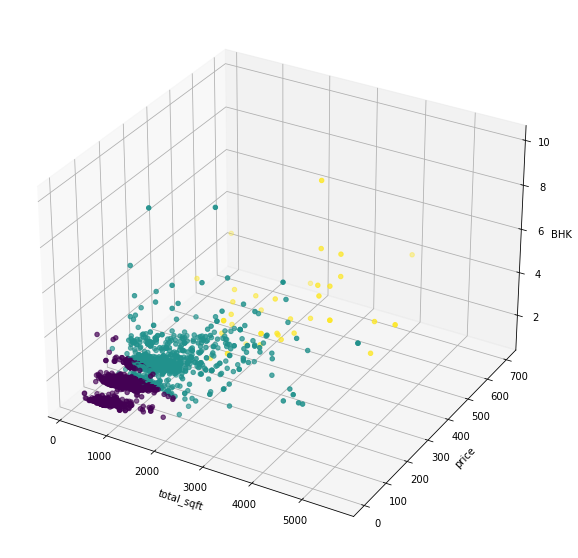

In [163]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pd_predictions.total_sqft, pd_predictions.price, pd_predictions.BHK, c=pd_predictions.prediction)
threedee.set_xlabel('total_sqft')
threedee.set_ylabel('price')
threedee.set_zlabel('BHK')
plt.show()

### From this clustering image is it clear how we divide the df in 3 main cluster representing in particular the houses low, medium and high level

# Random forest - house_condition bad=0 good=1

In [164]:
df4 = df2.alias('df4')

In [165]:
df4 = df4.drop('housetype','cordinates')

In [166]:
df4.printSchema()

root
 |-- house_condition: string (nullable = true)
 |-- BHK: double (nullable = true)
 |-- price: double (nullable = true)
 |-- per_month_emi: double (nullable = true)
 |-- total_sqft: double (nullable = true)



In [167]:
df4.show(3)

+---------------+---+-----+-------------+----------+
|house_condition|BHK|price|per_month_emi|total_sqft|
+---------------+---+-----+-------------+----------+
|            old|3.0| 75.0|        39.72|    1550.0|
|            old|2.0| 41.0|        21.71|    1000.0|
|            old|2.0|53.35|        28.25|     970.0|
+---------------+---+-----+-------------+----------+
only showing top 3 rows



## encoding

In [168]:
indexed = StringIndexer(inputCol="house_condition", outputCol="condition").fit(df4).transform(df4)

In [169]:
indexed = indexed.drop('house_condition')

In [170]:
indexed.tail(3)

[Row(BHK=3.0, price=57.51, per_month_emi=30.45, total_sqft=1475.0, condition=0.0),
 Row(BHK=1.0, price=15.0, per_month_emi=7.94, total_sqft=525.0, condition=0.0),
 Row(BHK=2.0, price=41.0, per_month_emi=21.71, total_sqft=1000.0, condition=0.0)]

In [171]:
assembler = VectorAssembler(inputCols = indexed.columns[:-1], outputCol = "features")

In [172]:
assembled = assembler.transform(indexed)

In [173]:
assembled.show(3)

+---+-----+-------------+----------+---------+--------------------+
|BHK|price|per_month_emi|total_sqft|condition|            features|
+---+-----+-------------+----------+---------+--------------------+
|3.0| 75.0|        39.72|    1550.0|      0.0|[3.0,75.0,39.72,1...|
|2.0| 41.0|        21.71|    1000.0|      0.0|[2.0,41.0,21.71,1...|
|2.0|53.35|        28.25|     970.0|      0.0|[2.0,53.35,28.25,...|
+---+-----+-------------+----------+---------+--------------------+
only showing top 3 rows



In [174]:
selected = assembled.select('features','condition')

## classifing RF

In [175]:
training_set, test_set = selected.randomSplit([0.8,0.2], seed=0)

In [176]:
from pyspark.ml.classification import RandomForestClassifier as RF

In [177]:
classifier = RF(maxDepth=5,numTrees=20,labelCol="condition")

In [178]:
model = classifier.fit(training_set)

In [179]:
model.featureImportances

SparseVector(4, {0: 0.0744, 1: 0.5634, 2: 0.2218, 3: 0.1404})

In [180]:
predictions = model.transform(test_set)

In [181]:
predictions.show(15)

+--------------------+---------+--------------------+--------------------+----------+
|            features|condition|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+----------+
|[1.0,7.94,7.94,65...|      0.0|[18.1055053172690...|[0.90527526586345...|       0.0|
|[1.0,7.94,7.94,65...|      0.0|[18.1055053172690...|[0.90527526586345...|       0.0|
|[1.0,7.94,7.94,65...|      0.0|[18.1055053172690...|[0.90527526586345...|       0.0|
|[1.0,7.94,7.94,69...|      0.0|[18.1055053172690...|[0.90527526586345...|       0.0|
|[1.0,7.94,7.94,69...|      0.0|[18.1055053172690...|[0.90527526586345...|       0.0|
|[1.0,8.47,8.47,53...|      0.0|[16.5328289941866...|[0.82664144970933...|       0.0|
|[1.0,8.47,8.47,57...|      0.0|[17.0188607402184...|[0.85094303701092...|       0.0|
|[1.0,8.47,8.47,60...|      0.0|[17.1912856156804...|[0.85956428078402...|       0.0|
|[1.0,9.38,9.38,67...|      0.0|[18.1055053172690...|[

## performance

In [182]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as Tester

In [183]:
tester = Tester(predictionCol='prediction', labelCol='condition')

In [184]:
accuracy = tester.evaluate(predictions)

In [185]:
print(f"Final accuracy is: {accuracy:5.4f}")

Final accuracy is: 0.6114


# Logistic regression

In [186]:
assembled.show(3)

+---+-----+-------------+----------+---------+--------------------+
|BHK|price|per_month_emi|total_sqft|condition|            features|
+---+-----+-------------+----------+---------+--------------------+
|3.0| 75.0|        39.72|    1550.0|      0.0|[3.0,75.0,39.72,1...|
|2.0| 41.0|        21.71|    1000.0|      0.0|[2.0,41.0,21.71,1...|
|2.0|53.35|        28.25|     970.0|      0.0|[2.0,53.35,28.25,...|
+---+-----+-------------+----------+---------+--------------------+
only showing top 3 rows



In [187]:
from pyspark.ml.feature import MinMaxScaler

In [188]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

In [189]:
model = scaler.fit(assembled)

In [190]:
scaled = model.transform(assembled).select('scaled_features','condition')

In [191]:
scaled = scaled.withColumnRenamed('scaled_features','features')

In [192]:
scaled.show(2)

+--------------------+---------+
|            features|condition|
+--------------------+---------+
|[0.22222222222222...|      0.0|
|[0.11111111111111...|      0.0|
+--------------------+---------+
only showing top 2 rows



In [193]:
training_set, test_set = scaled.randomSplit([0.7,0.3], seed=0)

In [194]:
from pyspark.ml.classification import LogisticRegression as LogisticRegressor

In [195]:
regressor = LogisticRegressor(featuresCol="features",labelCol='condition')

In [196]:
model = regressor.fit(training_set)

In [197]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BinaryEvaluator

In [198]:
performance = model.evaluate(test_set)

In [199]:
performance.predictions.show(10)

/usr/local/Cellar/apache-spark/3.2.1/libexec/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+---------+--------------------+--------------------+----------+
|            features|condition|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+----------+
|[0.0,0.0061648745...|      0.0|[0.20395623238426...|[0.55081303609384...|       0.0|
|[0.0,0.0070394265...|      0.0|[0.36310246399863...|[0.58979124509683...|       0.0|
|[0.0,0.0074265232...|      0.0|[0.23578511124101...|[0.55867469623798...|       0.0|
|[0.0,0.0077992831...|      0.0|[0.24101736867207...|[0.55996434853168...|       0.0|
|[0.0,0.0077992831...|      0.0|[0.24101736867207...|[0.55996434853168...|       0.0|
|[0.0,0.0077992831...|      0.0|[0.24101736867207...|[0.55996434853168...|       0.0|
|[0.0,0.0077992831...|      0.0|[0.25436690308451...|[0.56325105110275...|       0.0|
|[0.0,0.0077992831...|      0.0|[0.25436690308451...|[0.56325105110275...|       0.0|
|[0.0,0.0081863799...|      0.0|[0.22116376793461...|[

In [200]:
predictions = performance.predictions.select('condition','prediction')

In [201]:
predictions.show(10)

+---------+----------+
|condition|prediction|
+---------+----------+
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
+---------+----------+
only showing top 10 rows



In [202]:
evaluator = BinaryEvaluator(rawPredictionCol='prediction', labelCol='condition')

In [203]:
accuracy = evaluator.evaluate(predictions)

In [204]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.4914149190482856


### Unfortunately the classification results are not very good with an accuracy around 0.5%

## trying LR with pipeline 

In [205]:
df4.show(3)

+---------------+---+-----+-------------+----------+
|house_condition|BHK|price|per_month_emi|total_sqft|
+---------------+---+-----+-------------+----------+
|            old|3.0| 75.0|        39.72|    1550.0|
|            old|2.0| 41.0|        21.71|    1000.0|
|            old|2.0|53.35|        28.25|     970.0|
+---------------+---+-----+-------------+----------+
only showing top 3 rows



In [206]:
training_set, test_set = df4.randomSplit([0.7,0.3], seed=0)

In [207]:
from pyspark.ml import Pipeline

In [208]:
stage1 = StringIndexer(inputCol="house_condition", outputCol="house_condition_x")

In [209]:
stage2 = VectorAssembler(inputCols=['BHK', 'price', 'per_month_emi', 'total_sqft'],
                          outputCol='features')

In [210]:
stage3 = LogisticRegressor(featuresCol='features',labelCol='house_condition_x')

In [211]:
pipeline = Pipeline(stages= [stage1, stage2, stage3])

In [212]:
training_set.show(3)

+---------------+---+-----+-------------+----------+
|house_condition|BHK|price|per_month_emi|total_sqft|
+---------------+---+-----+-------------+----------+
|            new|1.0| 10.0|          5.3|     430.0|
|            new|1.0| 10.0|          5.3|     450.0|
|            new|1.0| 10.5|         5.56|     560.0|
+---------------+---+-----+-------------+----------+
only showing top 3 rows



In [213]:
model = pipeline.fit(training_set)

In [214]:
final_train = model.transform(training_set)

In [215]:
final_train.show(2)

+---------------+---+-----+-------------+----------+-----------------+--------------------+--------------------+--------------------+----------+
|house_condition|BHK|price|per_month_emi|total_sqft|house_condition_x|            features|       rawPrediction|         probability|prediction|
+---------------+---+-----+-------------+----------+-----------------+--------------------+--------------------+--------------------+----------+
|            new|1.0| 10.0|          5.3|     430.0|              1.0|[1.0,10.0,5.3,430.0]|[0.13611297237908...|[0.53397580420688...|       0.0|
|            new|1.0| 10.0|          5.3|     450.0|              1.0|[1.0,10.0,5.3,450.0]|[0.14149721930003...|[0.53531540230884...|       0.0|
+---------------+---+-----+-------------+----------+-----------------+--------------------+--------------------+--------------------+----------+
only showing top 2 rows



In [222]:
final_test = model.transform(test_set)

In [223]:
final_test.show(5)

+---------------+---+-----+-------------+----------+-----------------+--------------------+--------------------+--------------------+----------+
|house_condition|BHK|price|per_month_emi|total_sqft|house_condition_x|            features|       rawPrediction|         probability|prediction|
+---------------+---+-----+-------------+----------+-----------------+--------------------+--------------------+--------------------+----------+
|            new|1.0| 10.0|          5.3|     370.0|              1.0|[1.0,10.0,5.3,370.0]|[0.11996023161622...|[0.52995414536264...|       0.0|
|            new|1.0| 11.0|         5.83|     358.0|              1.0|[1.0,11.0,5.83,35...|[0.11273321799669...|[0.52815349443583...|       0.0|
|            new|1.0| 12.0|         6.35|     250.0|              1.0|[1.0,12.0,6.35,25...|[0.07966518700514...|[0.51990577013081...|       0.0|
|            new|1.0| 13.5|         7.15|     525.0|              1.0|[1.0,13.5,7.15,52...|[0.14770220004352...|[0.53685856567473.

In [224]:
final_test = final_test.select('house_condition_x','probability')

In [225]:
final_test.show(30)

+-----------------+--------------------+
|house_condition_x|         probability|
+-----------------+--------------------+
|              1.0|[0.52995414536264...|
|              1.0|[0.52815349443583...|
|              1.0|[0.51990577013081...|
|              1.0|[0.53685856567473...|
|              1.0|[0.54187496303689...|
|              1.0|[0.53803536704215...|
|              1.0|[0.53803536704215...|
|              1.0|[0.54137928553128...|
|              1.0|[0.53419041571369...|
|              1.0|[0.53987024445123...|
|              1.0|[0.53784353745494...|
|              1.0|[0.52852702726198...|
|              1.0|[0.52869315561446...|
|              1.0|[0.53034223627947...|
|              1.0|[0.53369357869559...|
|              1.0|[0.53603772828601...|
|              1.0|[0.54406210298437...|
|              1.0|[0.54439598522684...|
|              1.0|[0.54639843038973...|
|              1.0|[0.55206366758400...|
|              1.0|[0.53979106592790...|
|              1

22/04/26 22:52:30 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2627611 ms exceeds timeout 120000 ms
22/04/26 22:52:30 WARN SparkContext: Killing executors is not supported by current scheduler.
